In [11]:
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import models
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
import math

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

'''
You instantiate it with the same arguments used for the normalize. and then use it the same way

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(tensor)

'''

'\nYou instantiate it with the same arguments used for the normalize. and then use it the same way\n\nunorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))\nunorm(tensor)\n\n'

In [6]:
class resnet50(nn.Module):
    def __init__(self,num_classes=22):
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50(pretrained=True)
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

        
network = resnet50()
network.load_state_dict(torch.load('C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Dryad/model_resnet50_regressor_finetuned.pth',map_location=torch.device('cpu')))
network.eval()

C:\Users\nuhrr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nuhrr\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


resnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [12]:
# makke landmark predictions on Vol 22 adding to biological data xlsx. 

xlsx_dir = 'C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/nuhrvol22_results.xlsx'

V22 = "C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/V22/"

#xlsx = pd.read_excel(xlsx_dir, sep=';')
xlsx = pd.read_excel(xlsx_dir)
print(xlsx)

      Unnamed: 0       vpn   g  s  hc  wlmm  f left_good right_good
0              0  22077901  Gp  2   0  7.61  2         0          0
1              1  22077902  Gp  2   0  7.61  3         0          0
2              2  22077903  Gp  2   0  7.32  5         0          0
3              3  22077904  Gp  2   0  7.23  4         0          0
4              4  22077905  Gp  2   0  7.71  1         0          0
...          ...       ...  .. ..  ..   ... ..       ...        ...
7438        7438  22115516  Gp  1   0  6.94  4         0          1
7439        7439  22115517  Gp  1   0  6.94  3         0          0
7440        7440  22115518  Gp  1   0  6.84  6         0          0
7441        7441  22115519  Gp  2   0  6.75  5         0          0
7442        7442  22115520  Gp  2   0  7.32  6         0          0

[7443 rows x 9 columns]


In [4]:
pred_l = np.zeros((len(xlsx), 22))
pred_r = np.zeros((len(xlsx), 22))
counter = 0
start_time = time.time()
for row in range(len(xlsx)):
    counter += 1
    if counter == 3500:
        print('half way')
    page_number = str(xlsx.iloc[row, 1])[2:6].lstrip('0')
    image_number = str(xlsx.iloc[row, 1])[-2:]
    
    #   V22
    if f'V22P{page_number}L{image_number}L.bmp' in os.listdir(f'{V22}/page{page_number}/Picture/') and f'V22P{page_number}L{image_number}R.bmp' in os.listdir(f'{V22}/page{page_number}/Picture/'):
    #filename_ = 'V22P{}L{}L.bmp'.format(str(xlsx.iloc[row,0])[-5:-2],str(xlsx.iloc[row,0])[-2:])
    #if filename_ in os.listdir(V22 + 'page{}/Picture/'.format( str(xlsx.iloc[row,0])[-5:-2].lstrip('0') )):

        im_L = Image.open(f'{V22}/page{page_number}/Picture/V22P{page_number}L{image_number}L.bmp')

        with torch.no_grad():
            im_L = TF.resize(im_L, (224,224))
            im_L = TF.to_tensor(im_L)
            im_L = TF.normalize(im_L, [0.5], [0.5])
            im_L = torch.reshape(im_L, (1, 3, 224, 224))
            predictionL = (network(im_L) + 0.5)
            predictionL = predictionL.view(-1,11,2)*torch.tensor([1280, 1024])
            predictionL = predictionL.flatten()
            pred_l[row, :] = predictionL.numpy()

          

        im_R = Image.open(f'{V22}/page{page_number}/Picture/V22P{page_number}L{image_number}R.bmp')
        im_R = im_R.transpose(method=Image.FLIP_LEFT_RIGHT) 


        with torch.no_grad():
            im_R = TF.resize(im_R, (224,224))
            im_R = TF.to_tensor(im_R)
            im_R = TF.normalize(im_R, [0.5], [0.5])
            im_R = torch.reshape(im_R, (1, 3, 224, 224))
            predictionR = (network(im_R) + 0.5)
            predictionR = predictionR.view(-1,11,2)*torch.tensor([1280, 1024])
            predictionR = predictionR.flatten()
            pred_r[row, :] = predictionR.numpy()
           
    else:
        pred_l[row, :] = np.zeros((1,22))
        pred_r[row, :] = np.zeros((1,22))


pred_l = pd.DataFrame(pred_l, columns = ['l_x1','l_y1','l_x2','l_y2','l_x3','l_y3','l_x4','l_y4','l_x5','l_y5','l_x6','l_y6','l_x7','l_y7','l_x8','l_y8','l_x9','l_y9','l_x10','l_y10','l_x11','l_y11' ])
pred_r = pd.DataFrame(pred_r, columns = ['r_x1','r_y1','r_x2','r_y2','r_x3','r_y3','r_x4','r_y4','r_x5','r_y5','r_x6','r_y6','r_x7','r_y7','r_x8','r_y8','r_x9','r_y9','r_x10','r_y10','r_x11','r_y11' ] )
xlsx = pd.concat([xlsx, pred_l, pred_r], axis=1)

print("Total Elapsed Time : {} s".format(time.time()-start_time))
xlsx.to_excel('C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/regression_results.xlsx')

      Unnamed: 0       vpn   g  s  hc  wlmm  f left_good right_good
0              0  22077901  Gp  2   0  7.61  2         0          0
1              1  22077902  Gp  2   0  7.61  3         0          0
2              2  22077903  Gp  2   0  7.32  5         0          0
3              3  22077904  Gp  2   0  7.23  4         0          0
4              4  22077905  Gp  2   0  7.71  1         0          0
...          ...       ...  .. ..  ..   ... ..       ...        ...
7438        7438  22115516  Gp  1   0  6.94  4         0          1
7439        7439  22115517  Gp  1   0  6.94  3         0          0
7440        7440  22115518  Gp  1   0  6.84  6         0          0
7441        7441  22115519  Gp  2   0  6.75  5         0          0
7442        7442  22115520  Gp  2   0  7.32  6         0          0

[7443 rows x 9 columns]
half way
Total Elapsed Time : 2380.1662702560425 s


In [5]:
xlsx_dir

'C:/Users/nuhrr/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/nuhrvol22_results.xlsx'

In [7]:
xlsx = pd.read_excel('C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/regression_results.xlsx', index_col=0)

In [8]:
xlsx

,Unnamed: 0,vpn,g,s,hc,wlmm,f,left_good,right_good,l_x1,...,r_x7,r_y7,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x11,r_y11
0,0,22077901,Gp,2,0,7.61,2,0,0,1116.413330,...,450.427826,665.775635,602.018372,723.141724,1078.337891,434.953613,658.194031,487.285828,956.266357,387.787781
1,1,22077902,Gp,2,0,7.61,3,0,0,1058.370605,...,416.803223,712.691406,573.963684,753.574097,1016.201660,427.777832,601.896851,518.133789,883.474731,395.640503
2,2,22077903,Gp,2,0,7.32,5,0,0,1046.984741,...,415.441162,741.863159,563.124084,777.472046,987.104614,451.846252,603.784790,545.683350,868.167419,421.171875
3,3,22077904,Gp,2,0,7.23,4,0,0,1025.239136,...,387.184418,722.112000,533.051270,764.305786,970.140869,469.387390,585.283081,539.527710,847.430664,434.247406
4,4,22077905,Gp,2,0,7.71,1,0,0,978.284241,...,410.448425,699.697510,571.839050,748.406250,1044.840820,426.717682,617.525879,509.326538,916.870667,387.414612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,7438,22115516,Gp,1,0,6.94,4,0,1,992.346802,...,461.961212,702.843262,600.052551,734.695557,990.970337,444.607483,628.322510,535.467346,879.874756,415.528137
7439,7439,22115517,Gp,1,0,6.94,3,0,0,962.874084,...,408.979034,727.828918,551.046204,766.143066,955.964294,471.814026,582.329346,549.529846,842.752197,435.414246
7440,7440,22115518,Gp,1,0,6.84,6,0,0,981.031189,...,459.998535,678.373291,609.076965,713.755249,1003.093262,419.301758,635.894836,500.062622,892.186035,388.423645
7441,7441,22115519,Gp,2,0,6.75,5,0,0,1061.116943,...,410.846924,712.588318,551.605286,750.664124,936.277161,444.847168,592.440796,522.516968,833.267700,412.146088


In [14]:
 #17,18    ---   27, 28  <-- landmark 0 
# 39, 40             ----   49, 50

# calculate distances and append to xlsx

dis_l = np.zeros((len(xlsx), 1))
dis_r = np.zeros((len(xlsx), 1))

In [13]:
for row in range(len(xlsx)):
    lp1 = [xlsx.loc[row, 'l_x1'], xlsx.loc[row,'l_y1']]
    lp6 = [xlsx.loc[row, 'l_x6'], xlsx.loc[row, 'l_y6']]
    rp1 = [xlsx.loc[row, 'r_x1'], xlsx.loc[row, 'r_y1']]
    rp6 = [xlsx.loc[row, 'r_x6'], xlsx.loc[row, 'r_y6']]
    distancel = math.sqrt( ((lp1[0]-lp6[0])**2)+((lp1[1]-lp6[1])**2) )
    distancer = math.sqrt( ((rp1[0]-rp6[0])**2)+((rp1[1]-rp6[1])**2) )
    dis_l[row, :] = distancel
    dis_r[row, :] = distancer
dis_l = pd.DataFrame(dis_l, columns = ['dis_l'])
dis_r = pd.DataFrame(dis_r, columns = ['dis_r'])
xlsx = pd.concat([xlsx, dis_l, dis_r], axis=1)
xlsx.to_excel('C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/final_unclean.xlsx')

KeyError: 'l_x1'

In [10]:
xlsx

,Unnamed: 0,vpn,g,s,hc,wlmm,f,left_good,right_good,l_x1,...,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x11,r_y11,dis_l,dis_r
0,0,22077901,Gp,2,0,7.61,2,0,0,1116.413330,...,602.018372,723.141724,1078.337891,434.953613,658.194031,487.285828,956.266357,387.787781,1107.771524,1098.062710
1,1,22077902,Gp,2,0,7.61,3,0,0,1058.370605,...,573.963684,753.574097,1016.201660,427.777832,601.896851,518.133789,883.474731,395.640503,1102.134388,1091.836122
2,2,22077903,Gp,2,0,7.32,5,0,0,1046.984741,...,563.124084,777.472046,987.104614,451.846252,603.784790,545.683350,868.167419,421.171875,1054.053681,1056.701373
3,3,22077904,Gp,2,0,7.23,4,0,0,1025.239136,...,533.051270,764.305786,970.140869,469.387390,585.283081,539.527710,847.430664,434.247406,1053.796171,1050.264875
4,4,22077905,Gp,2,0,7.71,1,0,0,978.284241,...,571.839050,748.406250,1044.840820,426.717682,617.525879,509.326538,916.870667,387.414612,1119.358830,1119.489692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,7438,22115516,Gp,1,0,6.94,4,0,1,992.346802,...,600.052551,734.695557,990.970337,444.607483,628.322510,535.467346,879.874756,415.528137,992.393949,990.340681
7439,7439,22115517,Gp,1,0,6.94,3,0,0,962.874084,...,551.046204,766.143066,955.964294,471.814026,582.329346,549.529846,842.752197,435.414246,1004.232405,993.652461
7440,7440,22115518,Gp,1,0,6.84,6,0,0,981.031189,...,609.076965,713.755249,1003.093262,419.301758,635.894836,500.062622,892.186035,388.423645,997.473612,991.759396
7441,7441,22115519,Gp,2,0,6.75,5,0,0,1061.116943,...,551.605286,750.664124,936.277161,444.847168,592.440796,522.516968,833.267700,412.146088,981.341316,966.412864


In [21]:
xlsx.iloc[:,9]

0       0
1       0
2       0
3       0
4       0
       ..
7438    1
7439    0
7440    0
7441    0
7442    0
Name: right_good, Length: 7443, dtype: object

In [22]:
xlsx.iloc[:,8]

0       0
1       0
2       0
3       0
4       0
       ..
7438    0
7439    0
7440    0
7441    0
7442    0
Name: left_good, Length: 7443, dtype: object

Clean data before continuing (remove incomplete wings)

In [ ]:
# print(len(xlsx))
# print(xlsx)
# lm_xlsx = xlsx[xlsx.iloc[:,7]== '0']
# print(len(lm_xlsx))
# xlsx[xlsx.iloc[:,8]== '0']

In [29]:
# Load cleaned data
xlsx_dir = 'C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/final_unclean.xlsx'
xlsx = pd.read_excel(xlsx_dir)
print(len(xlsx))
print(xlsx)

7443
      Unnamed: 0.1  Unnamed: 0       vpn   g  s  hc  wlmm  f left_good  \
0                0           0  22077901  Gp  2   0  7.61  2         0   
1                1           1  22077902  Gp  2   0  7.61  3         0   
2                2           2  22077903  Gp  2   0  7.32  5         0   
3                3           3  22077904  Gp  2   0  7.23  4         0   
4                4           4  22077905  Gp  2   0  7.71  1         0   
...            ...         ...       ...  .. ..  ..   ... ..       ...   
7438          7438        7438  22115516  Gp  1   0  6.94  4         0   
7439          7439        7439  22115517  Gp  1   0  6.94  3         0   
7440          7440        7440  22115518  Gp  1   0  6.84  6         0   
7441          7441        7441  22115519  Gp  2   0  6.75  5         0   
7442          7442        7442  22115520  Gp  2   0  7.32  6         0   

     right_good  ...        r_x8        r_y8         r_x9        r_y9  \
0             0  ...  602.018372 

In [53]:
xlsx.iloc[:, -1]

0       1098.062710
1       1091.836122
2       1056.701373
3       1050.264875
4       1119.489692
           ...     
7438     990.340681
7439     993.652461
7440     991.759396
7441     966.412864
7442    1049.550477
Name: dis_r, Length: 7443, dtype: float64

In [41]:
xlsx[xlsx.iloc[:, 8]==0]

,Unnamed: 0.1,Unnamed: 0,vpn,g,s,hc,wlmm,f,left_good,right_good,...,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x11,r_y11,dis_l,dis_r
0,0,0,22077901,Gp,2,0,7.61,2,0,0,...,602.018372,723.141724,1078.337891,434.953613,658.194031,487.285828,956.266357,387.787781,1107.771524,1098.062710
1,1,1,22077902,Gp,2,0,7.61,3,0,0,...,573.963684,753.574097,1016.201660,427.777832,601.896851,518.133789,883.474731,395.640503,1102.134388,1091.836122
2,2,2,22077903,Gp,2,0,7.32,5,0,0,...,563.124084,777.472046,987.104614,451.846252,603.784790,545.683350,868.167419,421.171875,1054.053681,1056.701373
3,3,3,22077904,Gp,2,0,7.23,4,0,0,...,533.051270,764.305786,970.140869,469.387390,585.283081,539.527710,847.430664,434.247406,1053.796171,1050.264875
4,4,4,22077905,Gp,2,0,7.71,1,0,0,...,571.839050,748.406250,1044.840820,426.717682,617.525879,509.326538,916.870667,387.414612,1119.358830,1119.489692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,7438,7438,22115516,Gp,1,0,6.94,4,0,1,...,600.052551,734.695557,990.970337,444.607483,628.322510,535.467346,879.874756,415.528137,992.393949,990.340681
7439,7439,7439,22115517,Gp,1,0,6.94,3,0,0,...,551.046204,766.143066,955.964294,471.814026,582.329346,549.529846,842.752197,435.414246,1004.232405,993.652461
7440,7440,7440,22115518,Gp,1,0,6.84,6,0,0,...,609.076965,713.755249,1003.093262,419.301758,635.894836,500.062622,892.186035,388.423645,997.473612,991.759396
7441,7441,7441,22115519,Gp,2,0,6.75,5,0,0,...,551.605286,750.664124,936.277161,444.847168,592.440796,522.516968,833.267700,412.146088,981.341316,966.412864


In [46]:
xlsx.iloc[:, 6].min()

5.199999809265137

In [47]:
xlsx.iloc[:, 6].max()

8.1899995803833

In [48]:
xlsx.iloc[:, -1].min()/100

0.0

In [49]:
xlsx.iloc[:, -1].max()/100

11.78213064406509

In [16]:
#lm_xlsx = xlsx[xlsx.iloc[:, 8] == 0]
#print(f"Filtered rows in lm_csv w/o left_bad: {len(lm_xlsx)}")
lm_xlsx = xlsx[xlsx.iloc[:, 9] == 0]
print(f"Filtered rows in lm_csv w/o right_bad: {len(lm_xlsx)}")

Filtered rows in lm_csv w/o left_bad: 6171


IndexError: single positional indexer is out-of-bounds

In [15]:
# Plotting
for i in range(len(lm_xlsx)):
    if str(lm_xlsx.iloc[i, 1])[2:6].lstrip('0'): #not in [36, 48, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 224, 225, 228, 321, 336, 398, 328]:
        plt.scatter(lm_xlsx.iloc[i, 6], lm_xlsx.iloc[i, -1]/100, color='b', s=0.8)
plt.xlim(4,9)
plt.ylim(6,12)
plt.xlabel("wlmm")
plt.ylabel("prediction")
plt.show()

NameError: name 'lm_xlsx' is not defined

In [59]:
# linear regression 

linreg = LinearRegression()
linreg.fit(np.array(lm_xlsx.iloc[:,6]).reshape((-1,1)), lm_xlsx.iloc[:,-1]/100)
print('Test: we made it this far')
y_predicted = linreg.predict(np.array(lm_xlsx.iloc[:,6]).reshape(-1,1))

def RSE(y_true, y_predicted):
    """
    - y_true: Actual values
    - y_predicted: Predicted values
    """
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    RSS = np.sum(np.square(y_true - y_predicted))

    rse = math.sqrt(RSS / (len(y_true) - 2))
    return rse

def std_errors(y_true, y_predicted):

    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    std = np.std(abs(y_true - y_predicted))
    return std

print("Standard Errors:")
print(std_errors( lm_xlsx.iloc[:,-1]/100, y_predicted))

1
2
0.17811442119201173


In [63]:
print("R-squared:")
linreg.score(np.array(lm_xlsx.iloc[:,6]).reshape((-1,1)), lm_xlsx.iloc[:,-1]/100)

R-squared:


0.8459527483317291

C:\Users\nuhrr\AppData\Local\Temp\ipykernel_15540\369121987.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_xlsx['outlier'] = abs(filtered_xlsx['dis_r']/100 - y_predicted) > outlier_threshold


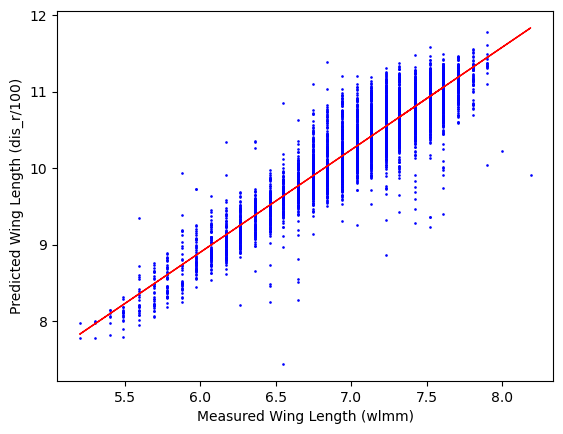

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

# Load the Excel file
xlsx = lm_xlsx
# xlsx_dir = 'C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/nuhrvol22_final_results.xlsx'
# xlsx = pd.read_excel(xlsx_dir)

# Filter the data where hc = 0 and right_good = 0
filtered_xlsx = xlsx[(xlsx['hc'] == 0) & (xlsx['right_good'] == 0)]

# Linear regression
linreg = LinearRegression()
linreg.fit(np.array(filtered_xlsx['wlmm']).reshape((-1, 1)), filtered_xlsx['dis_r']/100)
y_predicted = linreg.predict(np.array(filtered_xlsx['wlmm']).reshape((-1, 1)))

# Calculate standard error and identify outliers
std_error = np.std(abs(filtered_xlsx['dis_r']/100 - y_predicted))
outlier_threshold = 3 * std_error

# Create new variable to identify outliers based on vpn
filtered_xlsx['outlier'] = abs(filtered_xlsx['dis_r']/100 - y_predicted) > outlier_threshold

# Update the original dataframe with the outlier information
xlsx['outlier'] = filtered_xlsx['outlier'].reindex(xlsx.index, fill_value=False)

# Save the updated dataframe to a new Excel file
xlsx.to_excel('C:/Users/19480105/OneDrive - Stellenbosch University/Documents/1. Research Project/Data/Results/final_results_with_outliers.xlsx', index=False)

# Plotting
plt.scatter(filtered_xlsx['wlmm'], filtered_xlsx['dis_r']/100, color='b', s=0.8)
plt.plot(filtered_xlsx['wlmm'], y_predicted, color='r', linewidth=1)
plt.xlabel("Measured Wing Length (wlmm)")
plt.ylabel("Predicted Wing Length (dis_r/100)")
plt.show()
